In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.style as style
import matplotlib.pyplot as plt 
from google.colab import files
import tensorflow as tf

style.use('seaborn-dark')
print(tf.__version__)

2.3.0


In [47]:
upload_df = files.upload()

Saving Sunspots.csv to Sunspots (1).csv


In [170]:
df = pd.read_csv('Sunspots.csv')
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [171]:
time = np.array(df['Unnamed: 0'])
series = np.array(df['Monthly Mean Total Sunspot Number'])

In [50]:
def plot_series(time , series , start = 0 , end = None , text = None):
    plt.plot(time[start : end] , series[start : end] , label = text)
    if text:
        if text is list:
            plt.legend(text)
        else:
            plt.legend([text])
    plt.ylabel('Sunspot Value')
    plt.xlabel('Time')
    plt.title('Sunspot Time Series')

def split_dataset(series , time , split_val):
    time_train = time[:split_val]
    series_train = series[:split_val]
    time_val = time[split_val : ]
    series_val = series[split_val : ]
    return (time_train , series_train , time_val , series_val)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [173]:
time_train , series_train , time_val , series_val  = split_dataset(series , time , 2500)
print(len(time))

3252


In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(series_train.shape)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [98]:
tf.keras.backend.clear_session()

tf.random.set_seed(51)
np.random.seed(51)

window_size = 64
batch_size = 64
train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(series_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  # tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
39/39 [==============================] - 4s 95ms/step - loss: 144.5173 - mae: 145.0172
Epoch 2/100
39/39 [==============================] - 4s 106ms/step - loss: 77.8987 - mae: 78.3970
Epoch 3/100
39/39 [==============================] - 4s 106ms/step - loss: 52.3925 - mae: 52.8902
Epoch 4/100
39/39 [==============================] - 4s 107ms/step - loss: 49.6851 - mae: 50.1828
Epoch 5/100
39/39 [==============================] - 4s 106ms/step - loss: 48.6433 - mae: 49.1411
Epoch 6/100
39/39 [==============================] - 4s 107ms/step - loss: 47.6852 - mae: 48.1829
Epoch 7/100
39/39 [==============================] - 4s 106ms/step - loss: 46.8820 - mae: 47.3797
Epoch 8/100
39/39 [==============================] - 4s 107ms/step - loss: 46.0834 - mae: 46.5810
Epoch 9/100
39/39 [==============================] - 4s 106ms/step - loss: 45.3207 - mae: 45.8185
Epoch 10/100
39

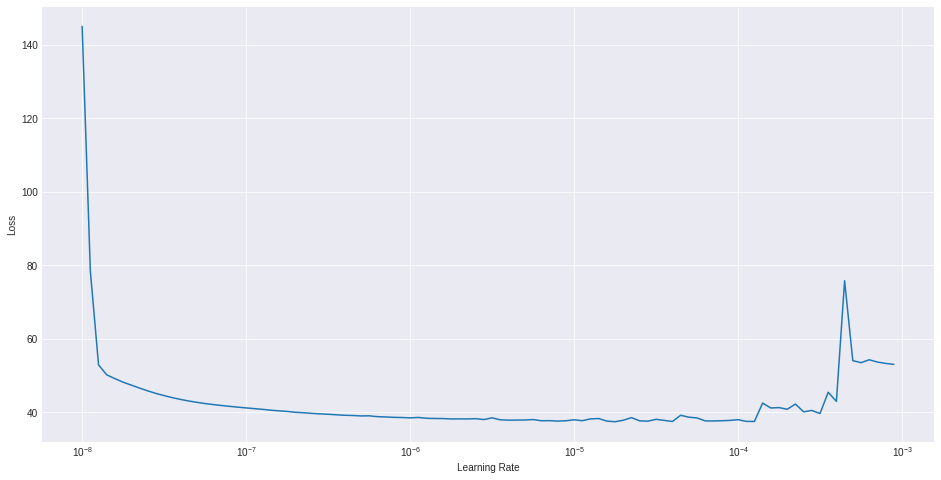

In [99]:
plt.figure(figsize = (16,8))
plt.semilogx(history.history['lr'] , history.history['mae'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [100]:
loss_x = 10000
lr_x = 10000
for lr , loss in zip(history.history['lr'] , history.history['mae']):
  if loss<loss_x:
    lr_x = lr
    loss_x = loss
print(loss_x , lr_x)

37.420318603515625 1.7782793e-05


In [103]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
39/39 [==============================] - 4s 90ms/step - loss: 58.2262 - mae: 58.7235
Epoch 2/500
39/39 [==============================] - 4s 100ms/step - loss: 26.4125 - mae: 26.9068
Epoch 3/500
39/39 [==============================] - 4s 100ms/step - loss: 23.2178 - mae: 23.7114
Epoch 4/500
39/39 [==============================] - 4s 99ms/step - loss: 21.1881 - mae: 21.6808
Epoch 5/500
39/39 [==============================] - 4s 100ms/step - loss: 20.5777 - mae: 21.0705
Epoch 6/500
39/39 [==============================] - 4s 99ms/step - loss: 19.9013 - mae: 20.3942
Epoch 7/500
39/39 [==============================] - 4s 99ms/step - loss: 19.4824 - mae: 19.9754
Epoch 8/500
39/39 [==============================] - 4s 100ms/step - loss: 19.0468 - mae: 19.5397
Epoch 9/500
39/39 [==============================] - 4s 101ms/step - loss: 18.6230 - mae: 19.1150
Epoch 10/500
39/39 [==============================] - 4s 99ms/step - loss: 18.9866 - mae: 19.4794
Epoch 11/500
39/39 [====

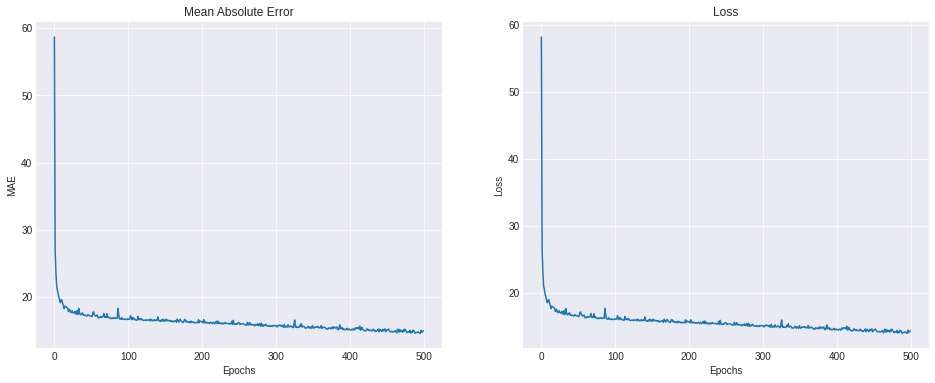

In [168]:
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(mae))

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
ax[0].grid()
ax[1].grid()
ax[0].plot(epochs , mae)
ax[1].plot(epochs , loss)
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('MAE')
ax[1].set_ylabel('Loss')
ax[0].set_title('Mean Absolute Error')
ax[1].set_title('Loss')
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

In [125]:
def model_forecast(model, series, window_size):
    series = np.expand_dims(series , axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [131]:
predict = model_forecast(model , series , window_size)[split_val - window_size:-1, -1, 0]

In [132]:
print(predict.shape)

(752,)


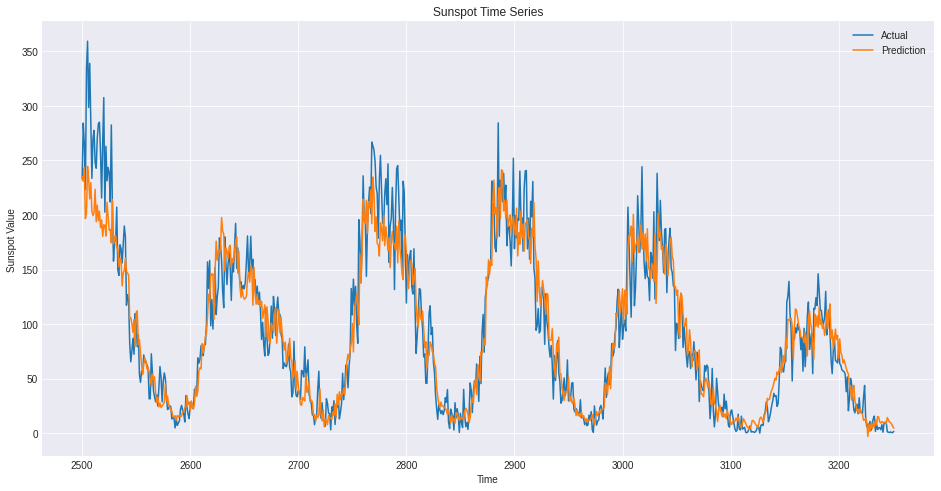

In [143]:
plt.figure(figsize = (16,8))
plot_series(time_val , series_val)
plot_series(time_val , predict)
plt.legend(['Actual' , 'Prediction'])
plt.grid(True)
plt.show()